# Tests with the particle amplitude


In [3]:
from scipy.io import loadmat
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append("..")
import yundon_functions as yf
import cv2


In [2]:
z, amp = loadmat("../../ultralytics/data_gen/TrackingResultBugs_4th_TrackingGroundTruthScript250319.mat")['BugXYZPositionAmpFinal'].T[[4,3]]


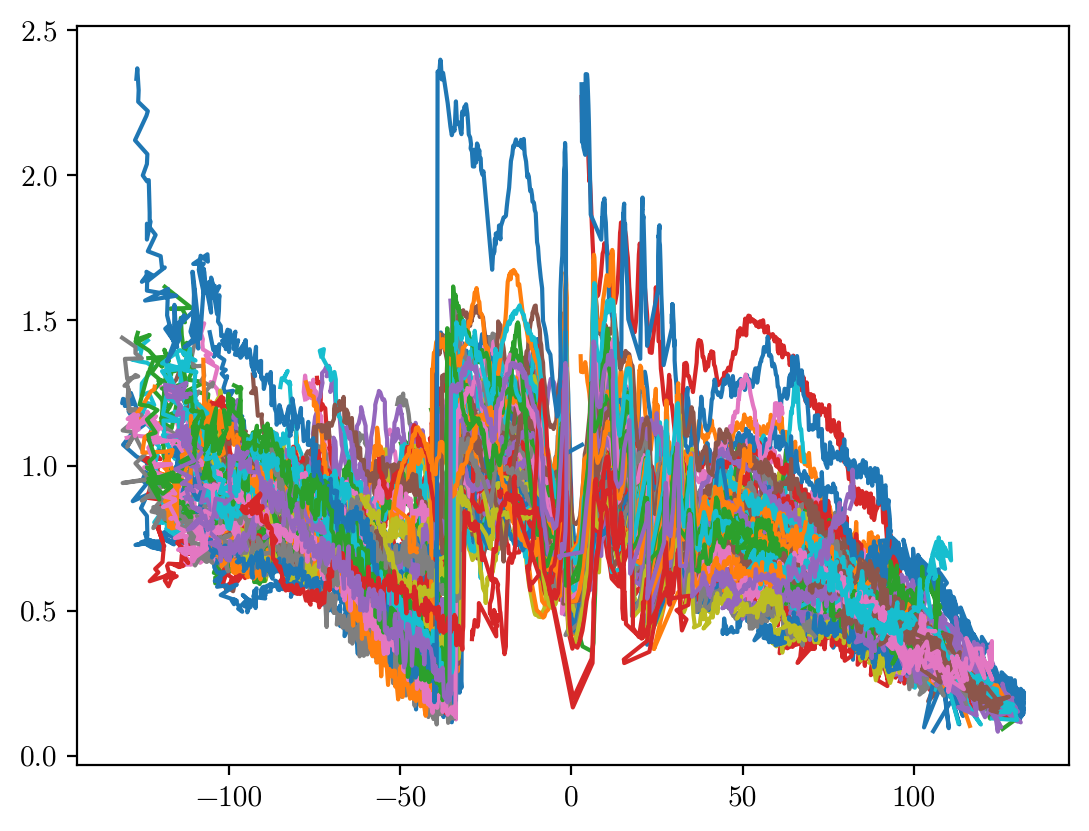

In [3]:
plt.figure(1).clf()
# z_interp = np.linspace(-133,133, 930)
z_refstack = np.arange(-761,1568-761)*0.134
z_refstack_inv = np.arange(-(1568-761), 761)*0.134

amp_list = []
for z_, amp_ in zip(z, amp):
    plt.plot(z_, amp_)
    if(np.any(amp_ > 2)):
        continue
    #print(z_)
    p,c = curve_fit(lambda x,a,b: a*x+b,np.arange(len(z_.flatten())),z_.flatten())
    z_fitted = p[0]*np.arange(len(z_.flatten()))+p[1]
    z_=-z_
    amp_list.append(np.interp(z_refstack, z_.flatten()[::-1], amp_.flatten()[::-1], left=np.nan, right=np.nan))
amp_list = np.array(amp_list)
# plt.show()

In [4]:
np.nanmean(amp_list), np.nanstd(amp_list)

(np.float64(0.7925322956103485), np.float64(0.24051569482680785))

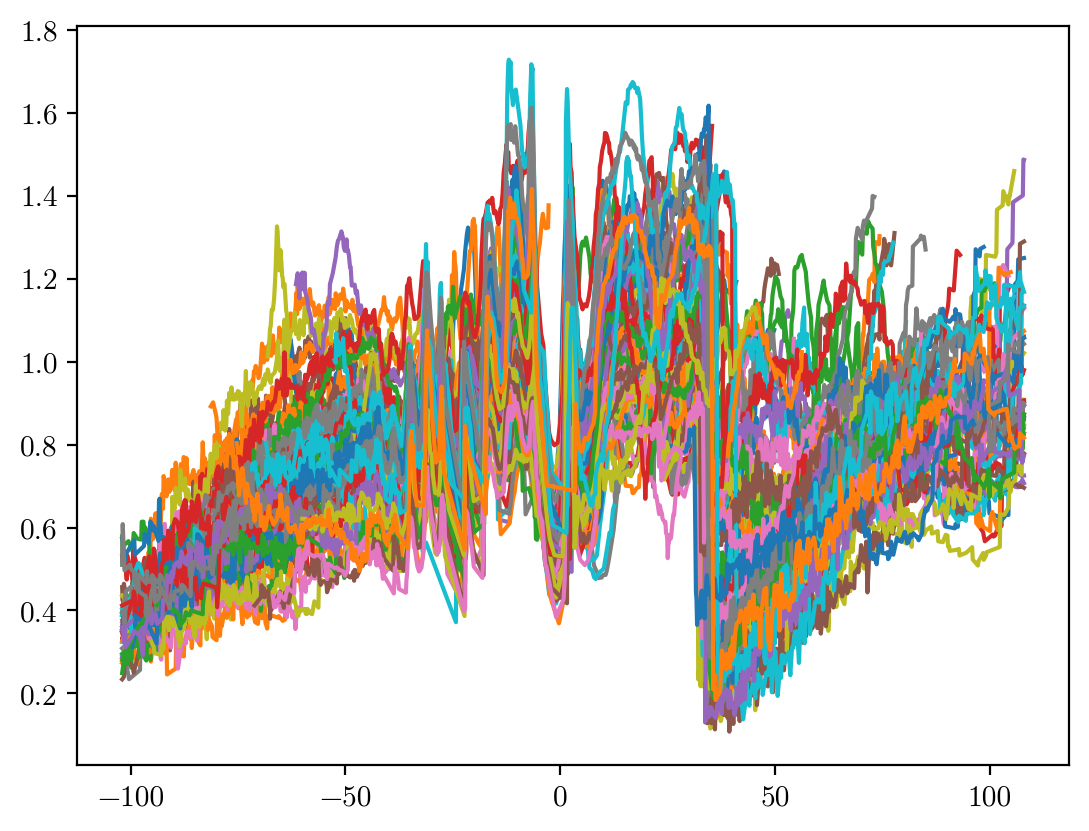

In [5]:
plt.figure(2).clf()
plt.plot(z_refstack,amp_list.T)
# plt.vlines(z_focus, ymin=np.ones_like(z_focus)*0.1, ymax=np.ones_like(z_focus)*1.6)
plt.show()

In [6]:
N = (~np.isnan(amp_list)).sum(axis=0)
amp_std = np.nanstd(amp_list, axis=0, ddof=1)#/np.sqrt(N)
amp_mean = np.nanmean(amp_list, axis=0)

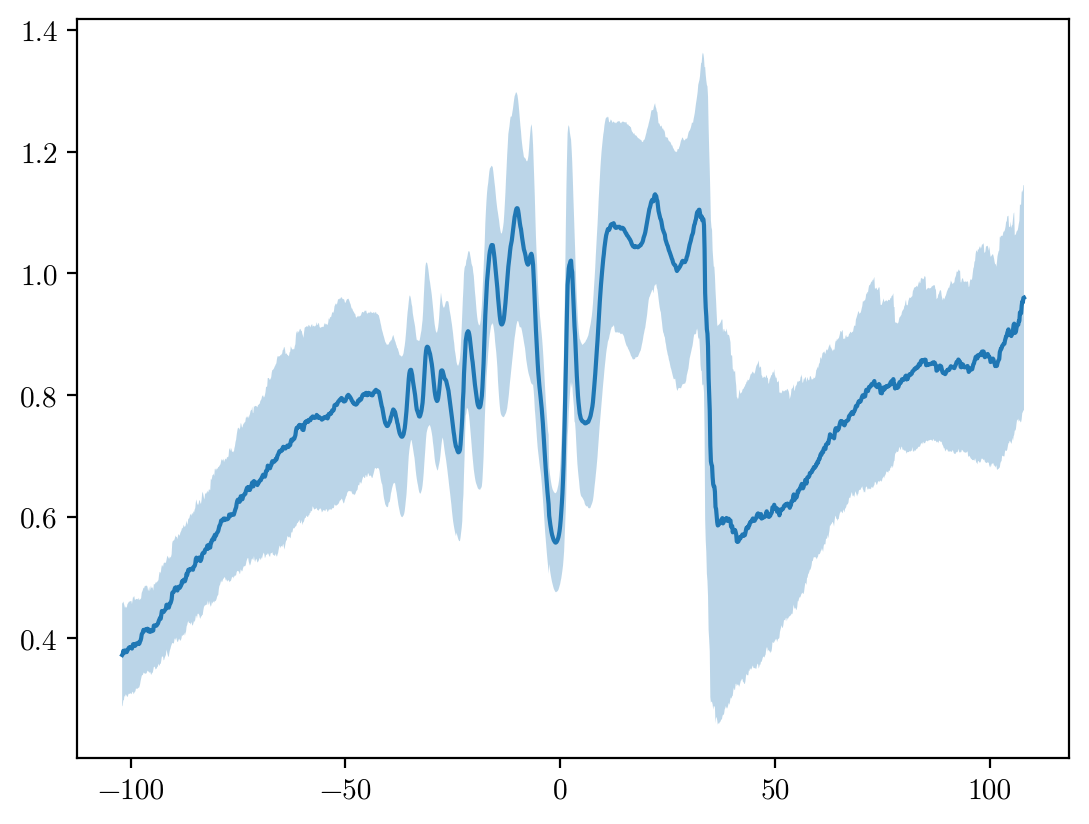

In [7]:
plt.figure(3)
plt.clf()
plt.fill_between(z_refstack, amp_mean-amp_std, amp_mean+amp_std, alpha=0.3)
plt.plot(z_refstack, amp_mean, color="tab:blue")
plt.show()

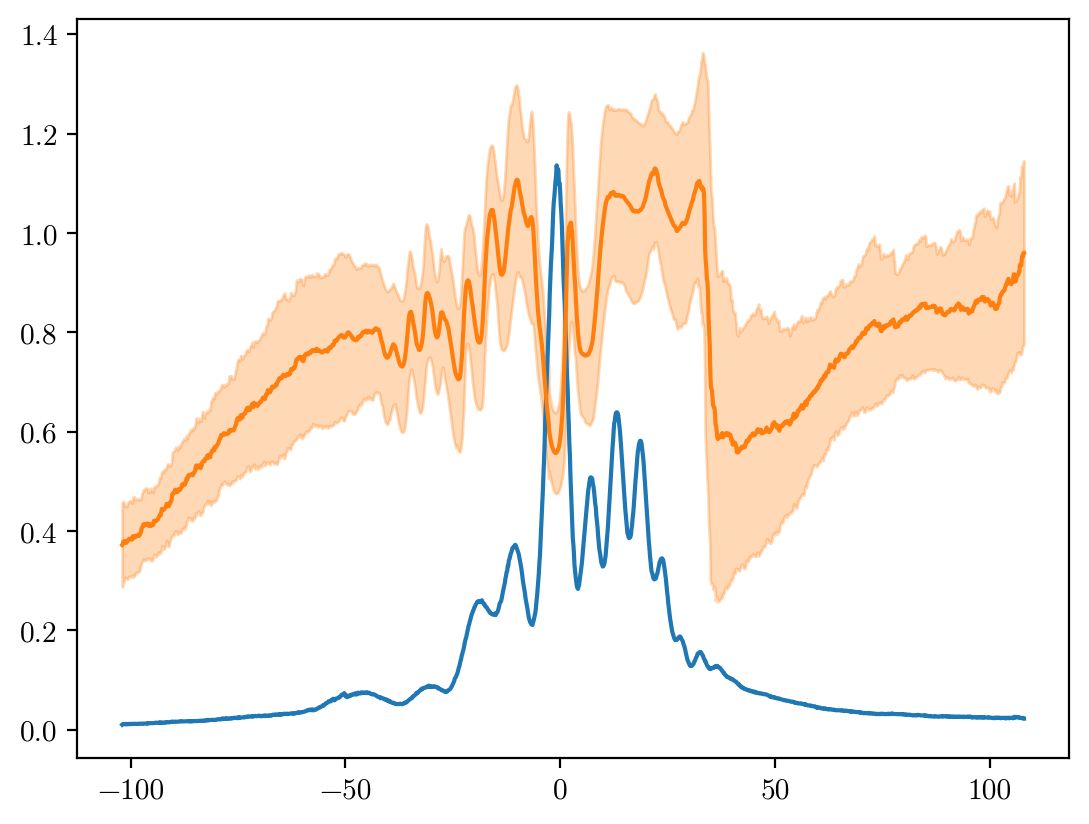

In [13]:
refstack_intensities = ((np.load("../ripples_downsampled.npy")-2e4)**2).mean(axis=(1,2))/10000
# plt.clf()
plt.plot(z_refstack,refstack_intensities)
plt.fill_between(z_refstack, amp_mean-amp_std, amp_mean+amp_std, alpha=0.3, color="tab:orange")
plt.plot(z_refstack, amp_mean,)

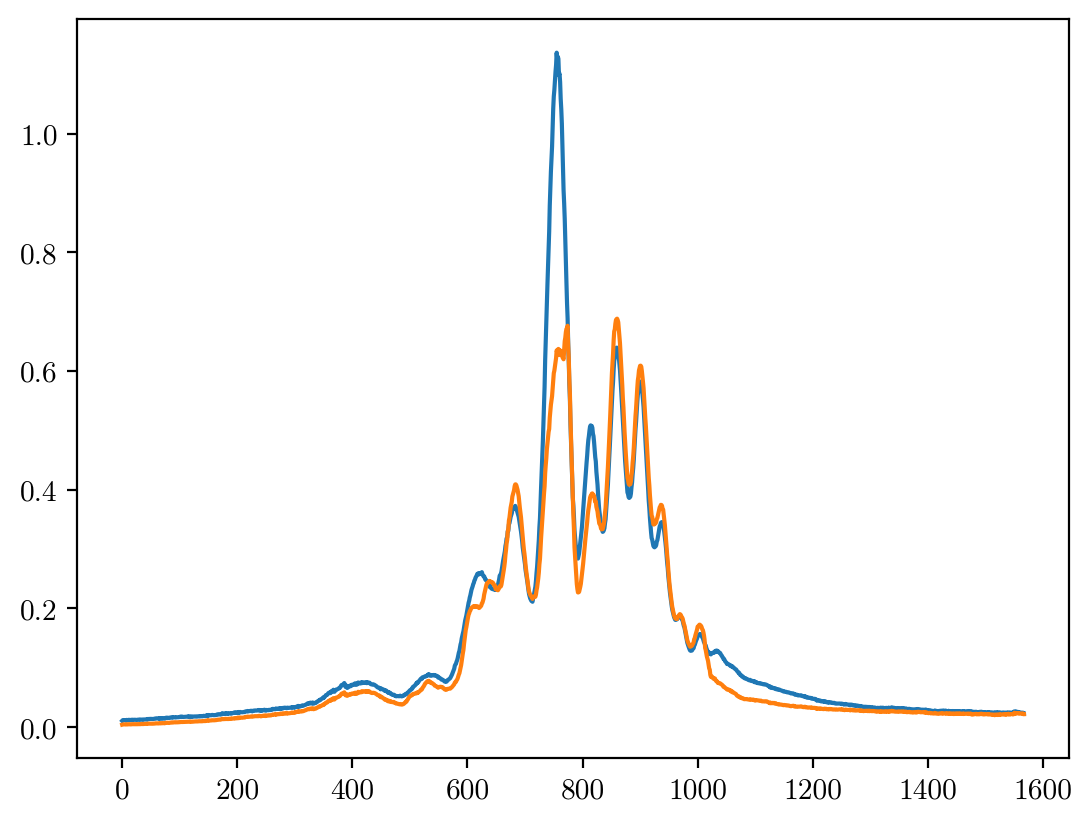

In [14]:
plt.plot(refstack_intensities)
# plt.plot(means*mean[::-1])
plt.plot(refstack_intensities*amp_mean)
# z_ref == z_refstack
plt.show()

In [10]:
np.save("amplitudes_2.npy", [z_refstack, mean, std])

NameError: name 'mean' is not defined

In [15]:
z_refstack, mean, std = np.load("../amplitudes.npy")

NameError: name 'means' is not defined

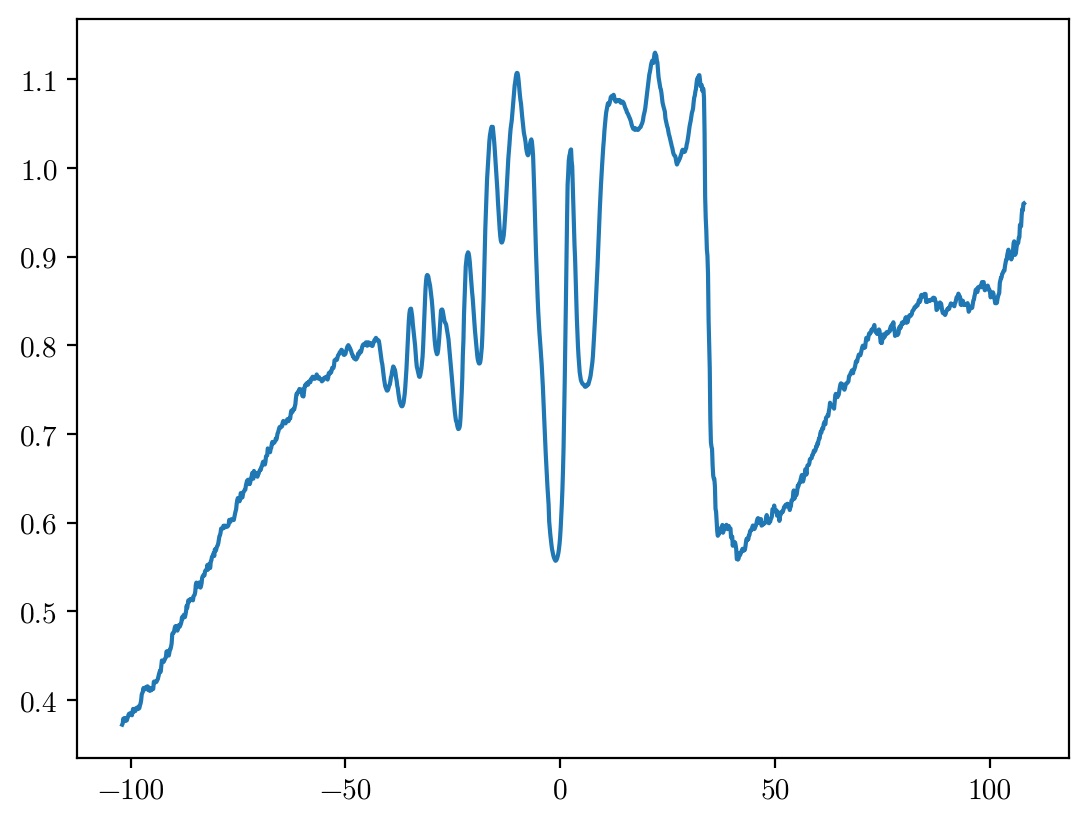

In [16]:
plt.plot(z_refstack,mean)
plt.plot(z_refstack,means)


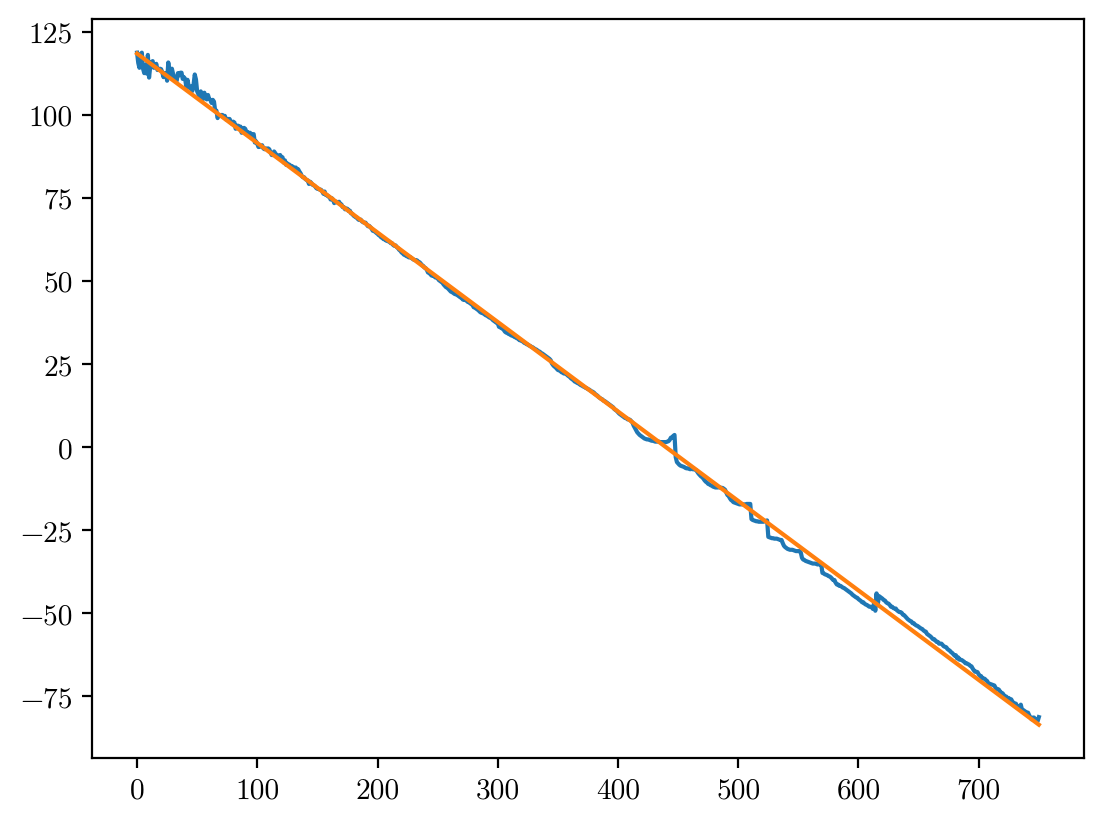

In [17]:
plt.plot(z_)

p,c = curve_fit(lambda x,a,b: a*x+b,np.arange(len(z_.flatten())),z_.flatten())
z_fitted = p[0]*np.arange(len(z_.flatten()))+p[1]
plt.plot(np.arange(len(z_.flatten())),p[0]*np.arange(len(z_.flatten()))+p[1])


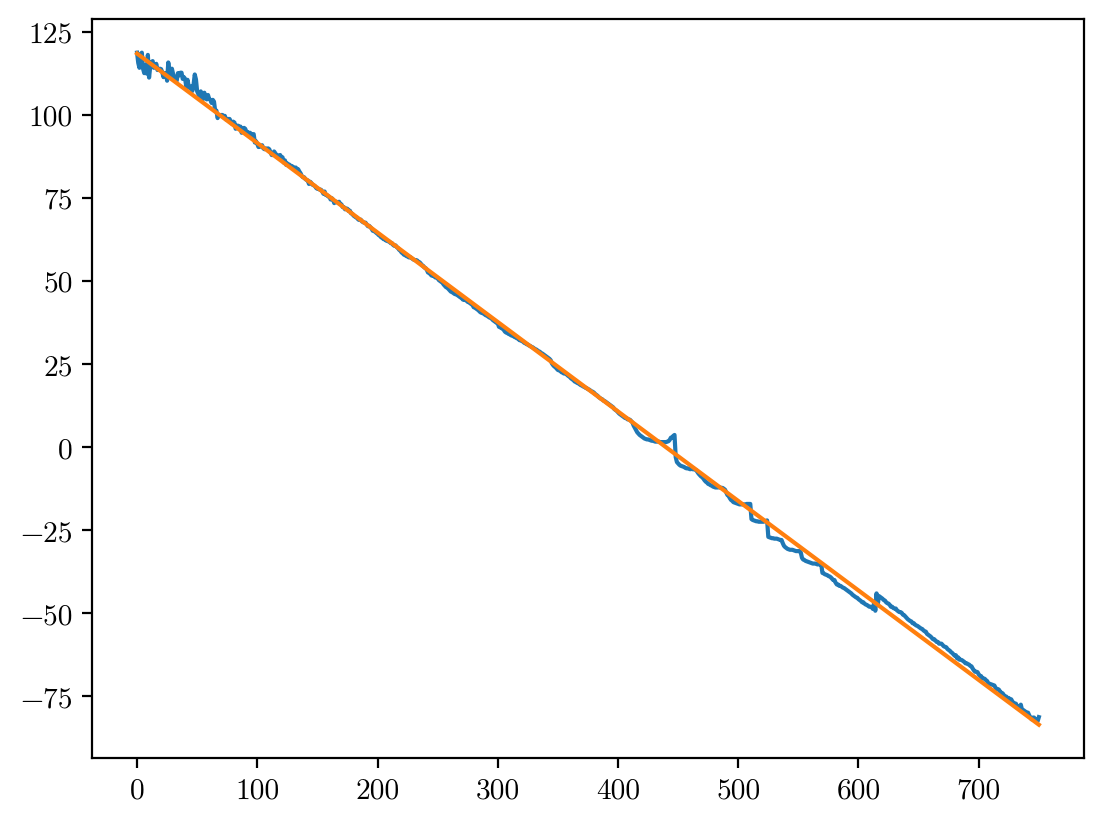

In [18]:
plt.plot(z_)
plt.plot(np.arange(len(z_.flatten())),p[0]*np.arange(len(z_.flatten()))+p[1])

100%|██████████| 1197/1197 [00:21<00:00, 54.94it/s]


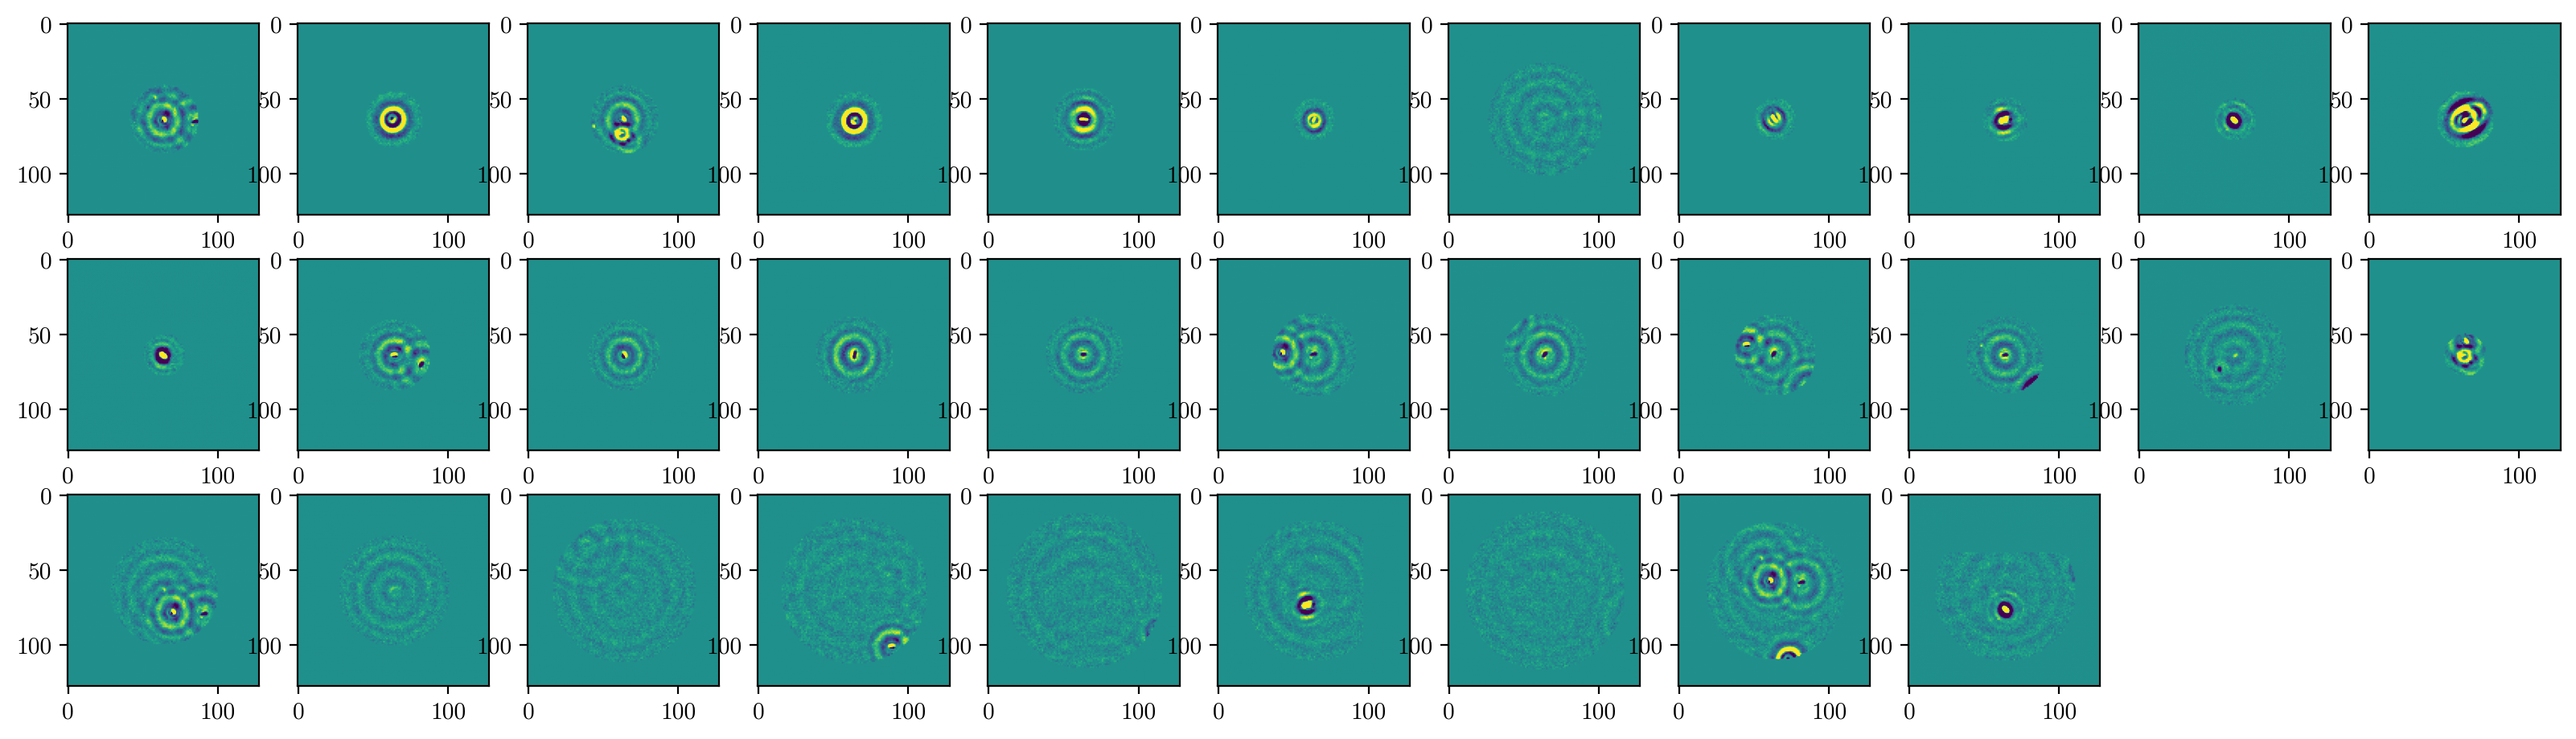

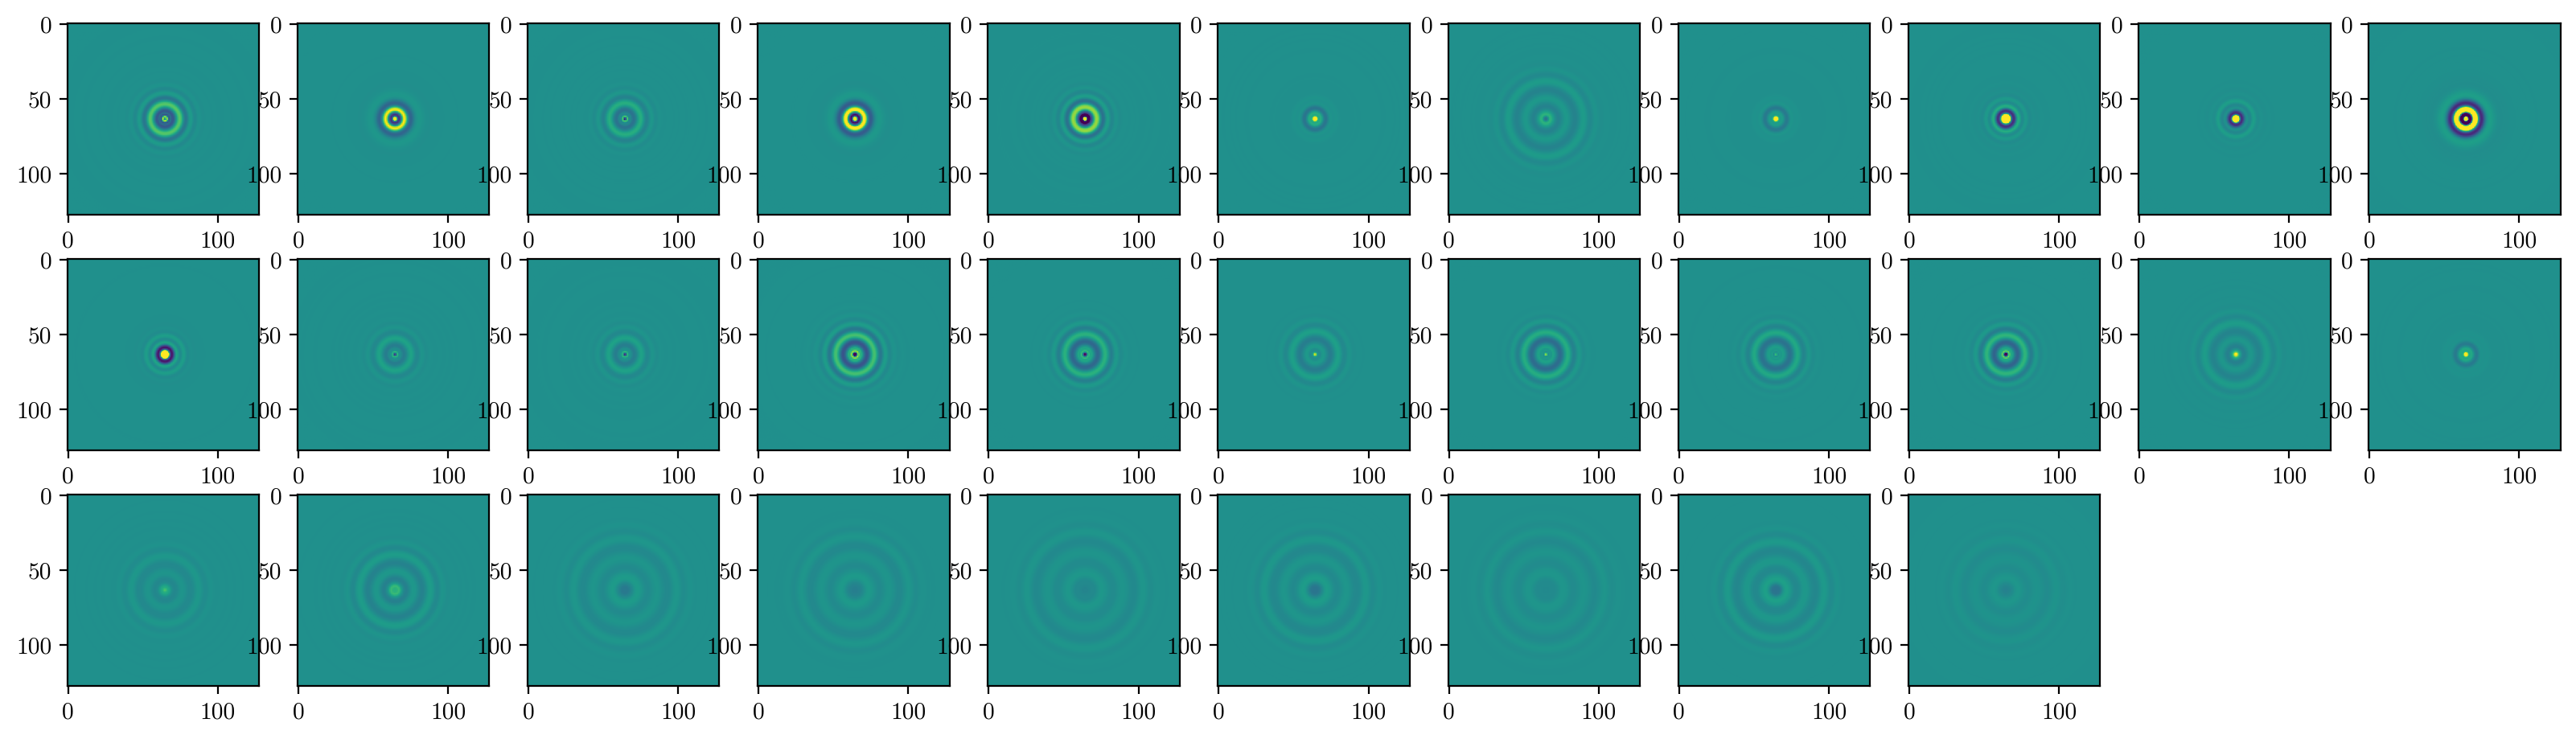

In [4]:
from scipy.optimize import minimize_scalar
from tqdm import tqdm
min_func = lambda alpha, img, ref : np.sum(np.square(img-alpha*ref))
image_size = 540,640            # Dimension 


downsampled_reference = np.load("../../ultralytics/data_gen/ripples_downsampled.npy")-2e4

padding=128
ref_size=128
amp_pair = []

x = np.arange(-ref_size//2, ref_size//2)
y = np.arange(-ref_size//2, ref_size//2)
xs, ys = np.meshgrid(x, y, sparse=True)
circle = np.sqrt(xs**2 + ys**2)
plt.figure(figsize=(20,2*70//11+1))
plt.figure(figsize=(20,2*70//11+1))

for slice in tqdm(range(1197)):
    gt_yundon = yf.gt_yundon(slice)
    yundon_img = yf.open_yundon_img(slice)
    padded_image = np.pad(cv2.resize(np.array(yundon_img),image_size[::-1]),padding,mode="constant",constant_values=2e4)-2e4
    for i,(x,y,z) in enumerate(zip(*gt_yundon)):
        x*=image_size[1]
        y*=image_size[0]
        
        x = np.round(x).astype(int)
        y = np.round(y).astype(int)
        z_index = (z)/0.134 + 761
        size = np.round((np.abs(z_index-761)*0.21+50)/(2)).astype(int)
        # print(size)
        if(size%2==1): size += 1
        mask = circle > size//2
        try:
            capture = np.pad(padded_image[y+padding-size//2:y+padding+size//2,x+padding-size//2:x+padding+size//2],(ref_size-size)//2,mode="constant",constant_values=0)
        except ValueError as e:
            print(y+padding-size//2,y+padding+size//2,x+padding-size//2,x+padding+size//2)
            print(x,y,z)
            raise e
        capture[mask] = 0



        ref = downsampled_reference[np.round(z_index).astype(int)]
        amp = minimize_scalar(min_func, args=(capture, ref))
        if(slice == 50):
            plt.figure(1)
            plt.subplot(70//11+1,11,i+1)

            plt.imshow(capture,vmin=-0.05e4,vmax=0.05e4)
            plt.figure(2)
            plt.subplot(70//11+1,11,i+1)
            plt.imshow(ref*amp.x,vmin=-0.05e4,vmax=0.05e4)
        amp_pair.append([z,amp.x, amp.fun])



In [5]:
z, amp,fun = np.array(amp_pair).T
z_mask = z > -102
z=z[z_mask]
amp=amp[z_mask]
amp_mask = (amp > 1e-6) & (amp < 1.75)
z=z[amp_mask]
amp=amp[amp_mask]

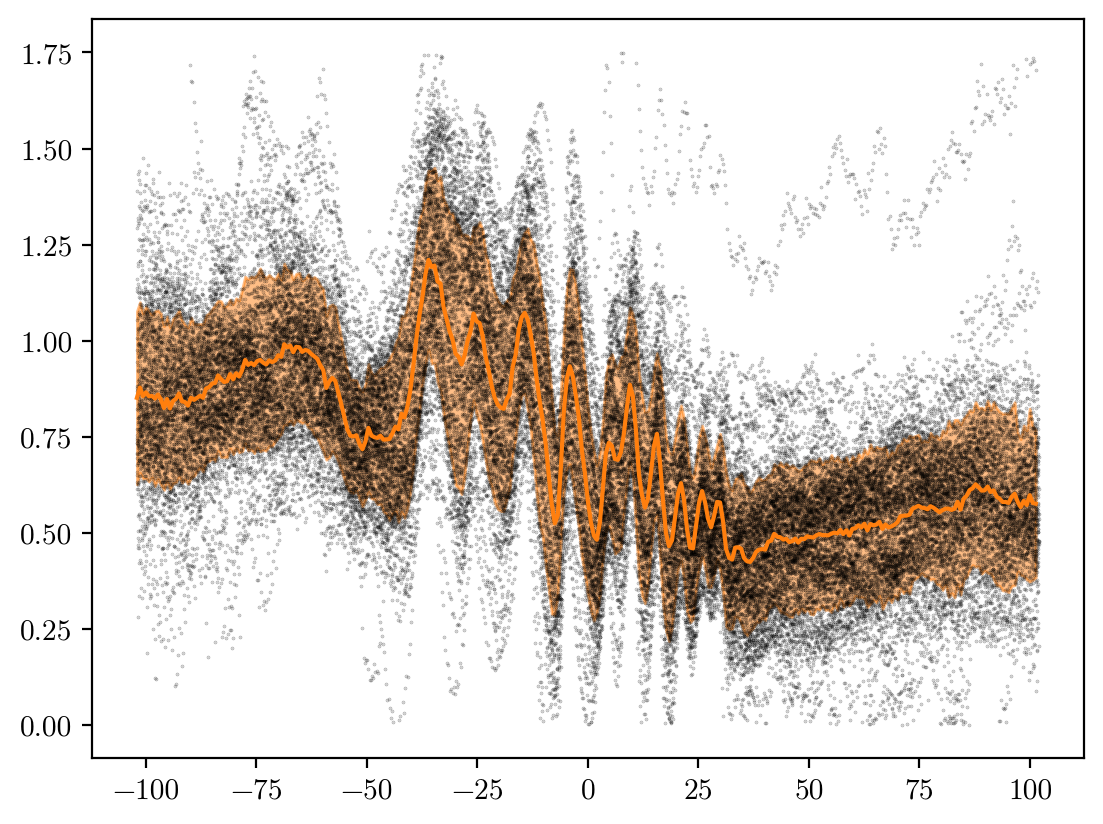

In [6]:
from scipy.stats import binned_statistic
bins = 300
amp_mean,x,_ = binned_statistic(z,amp,"mean",bins=bins)
amp_std,x,_ = binned_statistic(z,amp,"std",bins=bins)
plt.fill_between(x[:-1],amp_mean-amp_std, amp_mean+amp_std, alpha=0.5, color="tab:orange")
plt.plot(x[:-1],amp_mean,c="tab:orange")
plt.scatter(z, amp, s=0.1, c="k", alpha=0.3)

In [7]:
amp.mean(), amp.std()

(np.float64(0.7214932053172098), np.float64(0.29657159145178674))